In [7]:
#Importing required packages.
import pandas as pd
import numpy as np
import graphviz 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

Questo è l'inizio del notebook sul classificatore EnIA che predice in base ai dati meteo e del terreno, se è neccesario o no irrigare un terreno agricolo.
La variabile categorica da predire sarà irrigation, che potrà assumere 4 valori diversi: [No, Bassa, Media, Alta] che indica il livello di acqua che l'irrigatore dovrà distribuire

Importing Data and Data Preparation

In [8]:
#load training data
irrigazione = pd.read_csv('Dataset\DatasetEnIA.csv')
#round the decimal data to 2 decimal places
irrigazione = irrigazione.round(2)
#drop weathercode (wmo code) column
irrigazione = irrigazione.drop(columns=['weathercode (wmo code)'])

In [9]:
#drop weathercode (wmo code)
irrigazione.transpose()

,0,1,2,3,4,5,6,7,8,9,...,4739,4740,4741,4742,4743,4744,4745,4746,4747,4748
time,2010-01-01,2010-01-02,2010-01-03,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-09,2010-01-10,...,2022-12-23,2022-12-24,2022-12-25,2022-12-26,2022-12-27,2022-12-28,2022-12-29,2022-12-30,2022-12-31,2023-01-01
surface_pressure (hPa),983.0,990.18,1001.91,1000.48,988.98,987.31,993.74,986.75,986.74,994.92,...,1002.05,1003.45,1008.94,1012.95,1012.21,1011.15,1010.72,1010.27,1014.62,1015.97
soil_moisture_0_to_7cm (m³/m³),0.43,0.41,0.39,0.4,0.42,0.42,0.41,0.42,0.42,0.43,...,0.36,0.36,0.36,0.36,0.35,0.35,0.35,0.35,0.35,0.35
et0_fao_evapotranspiration (mm),0.98,1.54,1.48,0.59,0.65,0.8,1.04,0.49,0.68,0.84,...,0.79,0.62,0.73,0.66,0.88,0.88,0.96,0.82,0.97,1.03
rain (mm),37.9,5.1,0.0,11.3,7.7,23.9,7.9,31.3,28.5,10.0,...,0.1,0.3,0.0,0.0,0.0,0.0,0.8,0.9,0.0,0.0
windspeed_10m (km/h),25.43,21.95,11.36,9.02,8.98,16.11,10.23,14.38,15.85,9.55,...,3.73,3.49,3.21,3.67,3.4,3.73,5.59,6.42,3.22,3.11
relativehumidity_2m (%),83.54,76.42,59.25,77.58,87.79,86.71,83.75,86.71,84.62,81.38,...,91.12,93.17,90.17,90.46,88.96,89.29,87.38,87.04,87.88,92.38
temperature_2m (°C),11.3,10.77,7.72,7.63,12.6,11.79,11.41,12.23,9.33,7.61,...,12.06,13.22,13.5,12.91,13.06,12.78,12.42,12.91,13.2,12.37
soil_temperature_0_to_7cm (°C),12.21,11.5,10.01,8.84,11.65,12.04,11.95,11.95,10.56,9.14,...,11.99,12.74,13.22,12.9,12.73,12.5,12.33,12.48,12.32,11.52
cloudcover (%),76.67,50.12,39.58,97.54,91.21,81.67,54.71,86.62,77.08,74.25,...,48.5,90.75,51.58,82.54,76.12,47.42,54.54,68.38,26.62,21.88


Eliminiamo la colonna Time, non ci serve

In [10]:
irrigazione = irrigazione.drop(['time'], axis=1)

Convertiamo crop e stageOfGrowth alla loro rappresentazione numerica usando gli array

In [11]:
CropType = ["Barley", "Bean", "Cabbage", "Carrot", "Cotton", "Cucumber", "Eggplant", "Grain", "Lentil", "Lettuce"]
GrowthType = ["InitialStage", "CropDevStage", "MidSeasonStage", "LateSeasonStage"]

irrigazione["crop"] = irrigazione["crop"].apply(lambda x: CropType.index(x))
irrigazione['stageOfGrowth'] = irrigazione['stageOfGrowth'].apply(lambda x: GrowthType.index(x))

In [12]:
irrigazione

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc,irrigation
0,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,3,3,0.90,0
1,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,4,2,1.15,0
2,1001.91,0.39,1.48,0.0,11.36,59.25,7.72,10.01,39.58,1931.0,9,2,1.00,1
3,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,4,1,0.75,0
4,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,5,1,0.70,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744,1011.15,0.35,0.88,0.0,3.73,89.29,12.78,12.50,47.42,1624.0,2,0,0.45,1
4745,1010.72,0.35,0.96,0.8,5.59,87.38,12.42,12.33,54.54,1692.0,1,2,1.10,1
4746,1010.27,0.35,0.82,0.9,6.42,87.04,12.91,12.48,68.38,1280.0,1,0,0.35,1
4747,1014.62,0.35,0.97,0.0,3.22,87.88,13.20,12.32,26.62,1823.0,1,0,0.35,1


In [13]:
#Caratteristiche del nostro dataset
irrigazione.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
surface_pressure (hPa),4749.0,1000.576045,6.375738,972.91,997.24,1000.56,1004.15,1021.68
soil_moisture_0_to_7cm (m³/m³),4749.0,0.298705,0.094043,0.13,0.22,0.33,0.38,0.43
et0_fao_evapotranspiration (mm),4749.0,2.842723,1.572488,0.33,1.39,2.62,4.22,6.79
rain (mm),4749.0,3.292104,7.795533,0.00,0.00,0.00,2.20,79.70
windspeed_10m (km/h),4749.0,8.210164,4.030778,2.55,5.54,6.85,9.64,33.39
relativehumidity_2m (%),4749.0,76.026254,9.139055,42.75,70.67,77.29,82.83,95.04
temperature_2m (°C),4749.0,16.292331,6.134794,-0.80,11.17,15.55,21.73,29.08
soil_temperature_0_to_7cm (°C),4749.0,17.258577,6.685841,1.57,11.58,16.35,23.30,31.15
cloudcover (%),4749.0,36.063973,27.555232,0.00,12.04,30.54,56.62,100.00
shortwave_radiation (W/m²),4749.0,4350.670457,2134.954262,203.00,2342.00,4334.00,6297.00,8179.00


Data Cleaning

Non ci sono ne dati duplicati ne dati null

In [14]:
irrigazione.isnull().sum()

surface_pressure (hPa)             0
soil_moisture_0_to_7cm (m³/m³)     0
et0_fao_evapotranspiration (mm)    0
rain (mm)                          0
windspeed_10m (km/h)               0
relativehumidity_2m (%)            0
temperature_2m (°C)                0
soil_temperature_0_to_7cm (°C)     0
cloudcover (%)                     0
shortwave_radiation (W/m²)         0
crop                               0
stageOfGrowth                      0
Kc                                 0
irrigation                         0
dtype: int64

In [15]:
irrigazione.duplicated().sum()

0

Bilanciamento Dati

Si utilizzeranno due diverse tecniche di sampling, SMOTE e RANDOM UNDER SAMPLER.

<AxesSubplot: xlabel='irrigation', ylabel='count'>

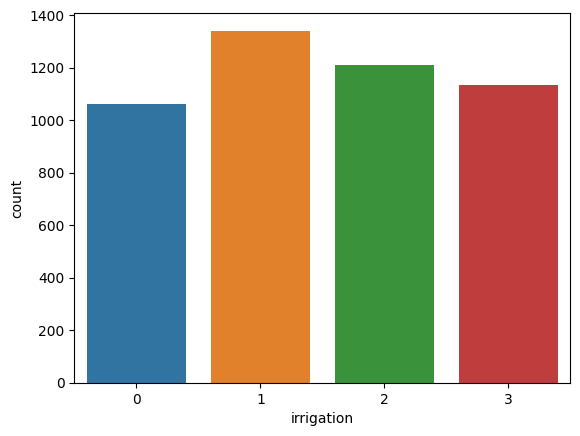

In [16]:
#La variabile categorica ha questi valori
sns.countplot(x='irrigation', data=irrigazione)

In [17]:
#undersample the dataset based on irrigation
rus = RandomUnderSampler(random_state=42)
X = irrigazione.drop('irrigation', axis=1)
y = irrigazione['irrigation']
X_res, y_res = rus.fit_resample(X, y)
#concatenate the undersampled dataset
irrigazione_under = pd.concat([X_res, y_res], axis=1)

In [18]:
irrigazione_under

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc,irrigation
0,983.00,0.43,0.98,37.9,25.43,83.54,11.30,12.21,76.67,1144.0,3,3,0.90,0
1,990.18,0.41,1.54,5.1,21.95,76.42,10.77,11.50,50.12,1792.0,4,2,1.15,0
2,1000.48,0.40,0.59,11.3,9.02,77.58,7.63,8.84,97.54,739.0,4,1,0.75,0
3,988.98,0.42,0.65,7.7,8.98,87.79,12.60,11.65,91.21,1105.0,5,1,0.70,0
4,987.31,0.42,0.80,23.9,16.11,86.71,11.79,12.04,81.67,1379.0,5,0,0.45,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243,1001.95,0.25,4.87,0.0,4.50,81.50,19.58,19.77,5.96,7600.0,3,1,0.75,3
4244,1000.76,0.28,3.48,0.0,8.51,67.25,13.61,15.76,37.25,6009.0,2,2,1.05,3
4245,1003.16,0.30,4.68,0.0,4.03,84.67,21.88,22.31,22.54,7073.0,1,3,0.90,3
4246,998.22,0.13,4.85,0.5,4.62,78.62,26.72,29.00,11.54,6644.0,5,3,0.75,3


In [19]:
#oversample the dataset using SMOTE
sm = SMOTE(random_state=42)
X = irrigazione.drop('irrigation', axis=1)
y = irrigazione['irrigation']
X_res, y_res = sm.fit_resample(X, y)
#concatenate the oversampled dataset
irrigazione_smote = pd.concat([X_res, y_res], axis=1)

In [20]:
irrigazione_smote

,surface_pressure (hPa),soil_moisture_0_to_7cm (m³/m³),et0_fao_evapotranspiration (mm),rain (mm),windspeed_10m (km/h),relativehumidity_2m (%),temperature_2m (°C),soil_temperature_0_to_7cm (°C),cloudcover (%),shortwave_radiation (W/m²),crop,stageOfGrowth,Kc,irrigation
0,983.000000,0.430000,0.980000,37.90000,25.430000,83.540000,11.300000,12.210000,76.670000,1144.000000,3,3,0.900000,0
1,990.180000,0.410000,1.540000,5.10000,21.950000,76.420000,10.770000,11.500000,50.120000,1792.000000,4,2,1.150000,0
2,1001.910000,0.390000,1.480000,0.00000,11.360000,59.250000,7.720000,10.010000,39.580000,1931.000000,9,2,1.000000,1
3,1000.480000,0.400000,0.590000,11.30000,9.020000,77.580000,7.630000,8.840000,97.540000,739.000000,4,1,0.750000,0
4,988.980000,0.420000,0.650000,7.70000,8.980000,87.790000,12.600000,11.650000,91.210000,1105.000000,5,1,0.700000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5359,993.320102,0.265697,4.511332,0.32121,8.381173,79.143894,19.660045,21.500650,14.287090,7241.496935,3,1,0.924847,3
5360,1002.395959,0.192121,5.177805,0.00000,4.926405,65.333046,23.163234,22.914973,36.210263,7248.132557,1,3,0.900000,3
5361,997.206823,0.279707,3.954353,0.33138,8.162251,80.805722,18.480472,20.185243,20.722934,6539.615083,6,2,0.982845,3
5362,1002.403447,0.227770,4.225012,0.00000,5.556620,75.802110,21.071451,22.775106,29.091240,6250.358619,5,2,0.758965,3


<AxesSubplot: xlabel='irrigation', ylabel='count'>

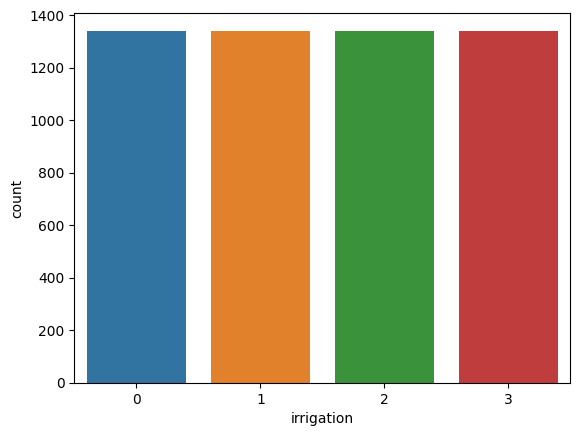

In [21]:
#La variabile categorica ha questi valori
sns.countplot(x='irrigation', data=irrigazione_smote)

Feature Selection

Useremo una matrice di corrispondenza per vedere quali degli attributi ci è più conveniente tenere per stimare
la variabile categorica irrigazione

<AxesSubplot: >

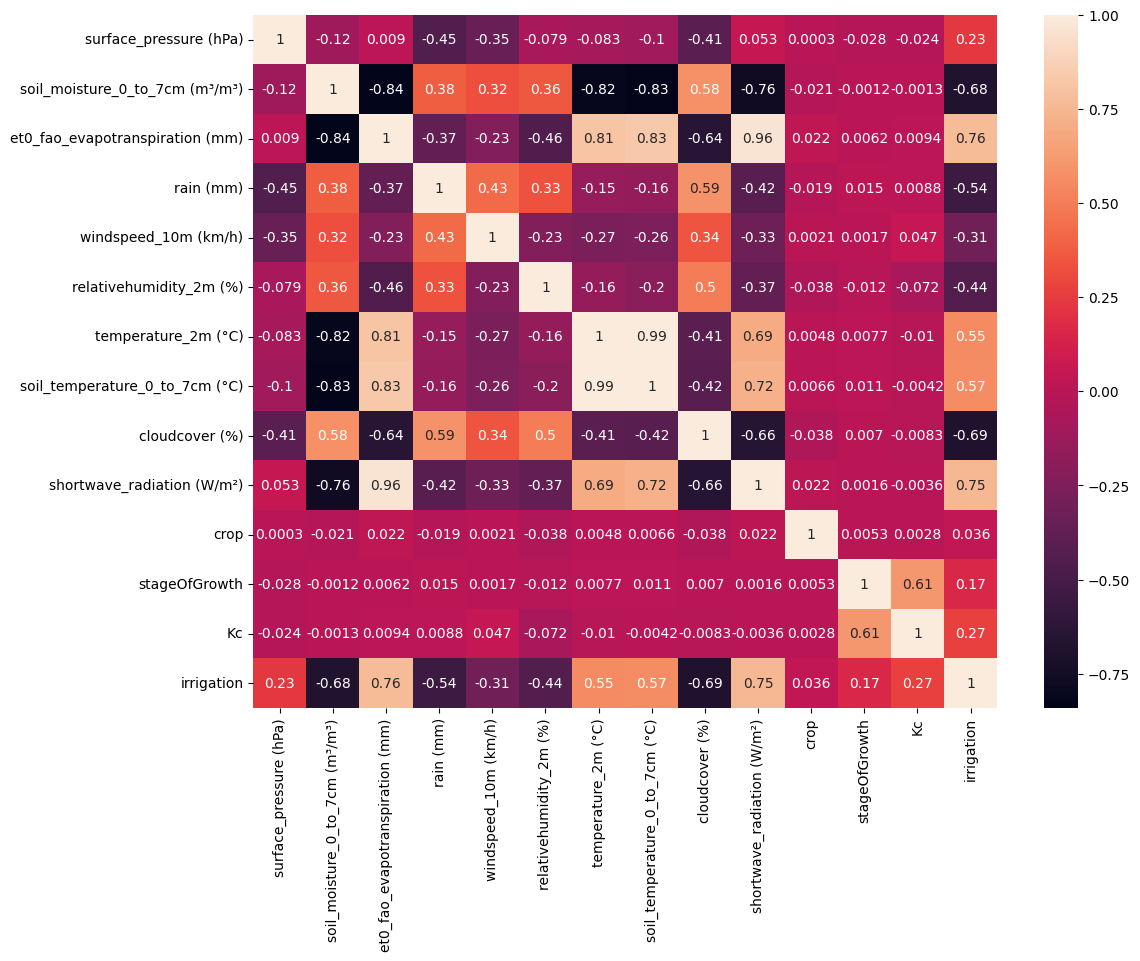

In [22]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

In [23]:
#crop ha una correlazione di 0.0049 quindi conviene eliminarla
irrigazione = irrigazione.drop("crop", axis=1)
#stage of growth ha una correlazione di 0.17 quindi conviene eliminarla
irrigazione = irrigazione.drop("stageOfGrowth",axis = 1)
#surface_pressure (hPa) ha una correlazione di 0.24 quindi conviene eliminarla
irrigazione = irrigazione.drop("surface_pressure (hPa)", axis = 1)
#Kc ha una correlazione di 0.28, tuttavia è una variabile importante per il nostro modello, dato che indica quanta acqua è in grado di trattenere la coltura, quindi non la eliminiamo

La matrice di corrispondenza ora avrà questo aspetto

<AxesSubplot: >

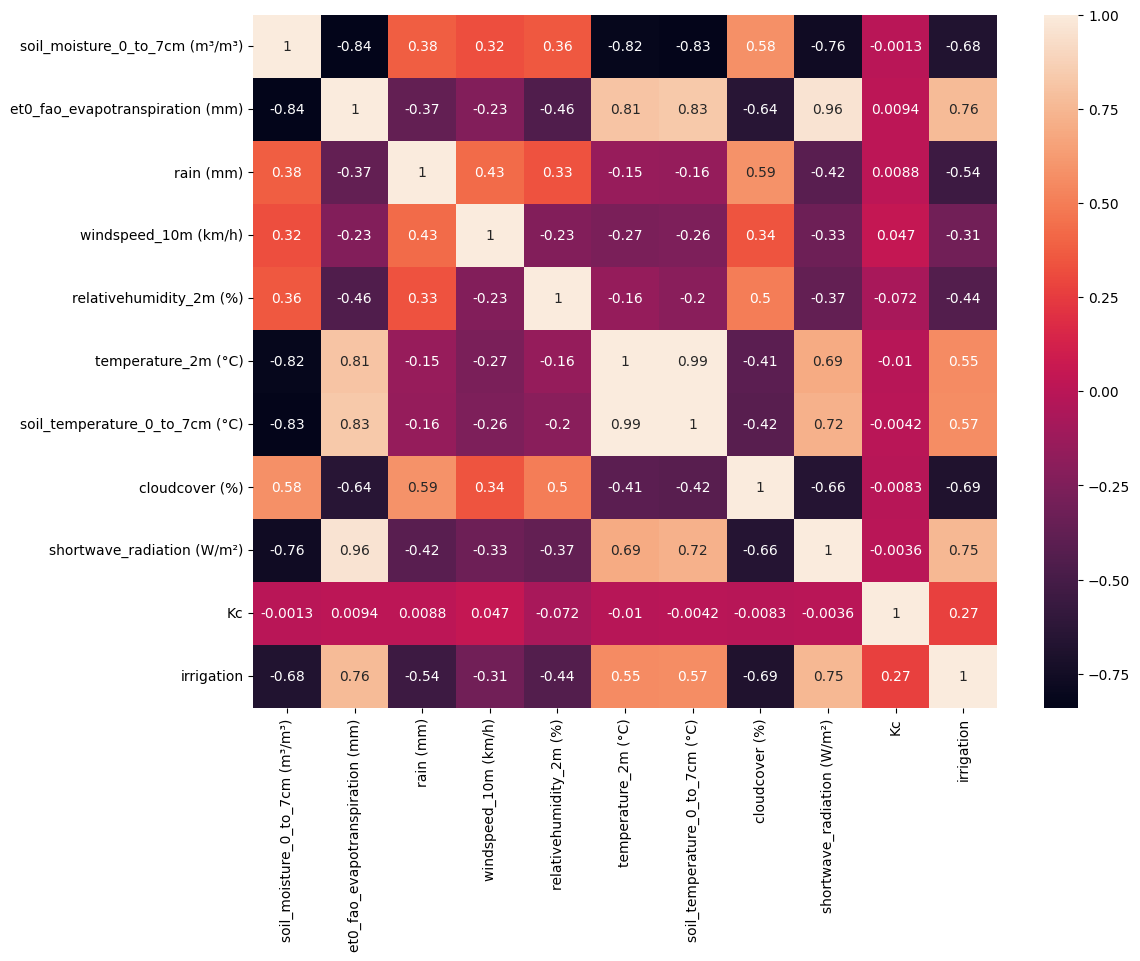

In [24]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

è convenitente eliminare i dati ridondanti e quelli che hanno una particolare corrispondenza con gli altri, elimineremo gli attributi che hanno un coefficiente di correlazione con altri attributi superiore o uguale a 0.6

In [25]:
#temperature_2m (°C) ha una correlazione di 0.99 con soil_temperature (°C) quindi conviene eliminarla, visto che
#soil_temperature (°C) ha una correlazione più alta con la variabile da predire
irrigazione = irrigazione.drop("temperature_2m (°C)", axis = 1)
#stesso discorso per soil_moisture e evapotranspiration
irrigazione = irrigazione.drop("soil_moisture_0_to_7cm (m³/m³)", axis = 1)
#stesso discorso per temperature_2m (°C) e evapotranspiration
irrigazione = irrigazione.drop("soil_temperature_0_to_7cm (°C)", axis = 1)
#stesso discordo per shortwave_radiation (W/m²) e evapotranspiration
irrigazione = irrigazione.drop("shortwave_radiation (W/m²)", axis = 1)
#stesso discordo per cloud_cover (%) e evapotranspiration
irrigazione = irrigazione.drop("cloudcover (%)", axis = 1)

La matrice di corrispondenza ora avrà questo aspetto

<AxesSubplot: >

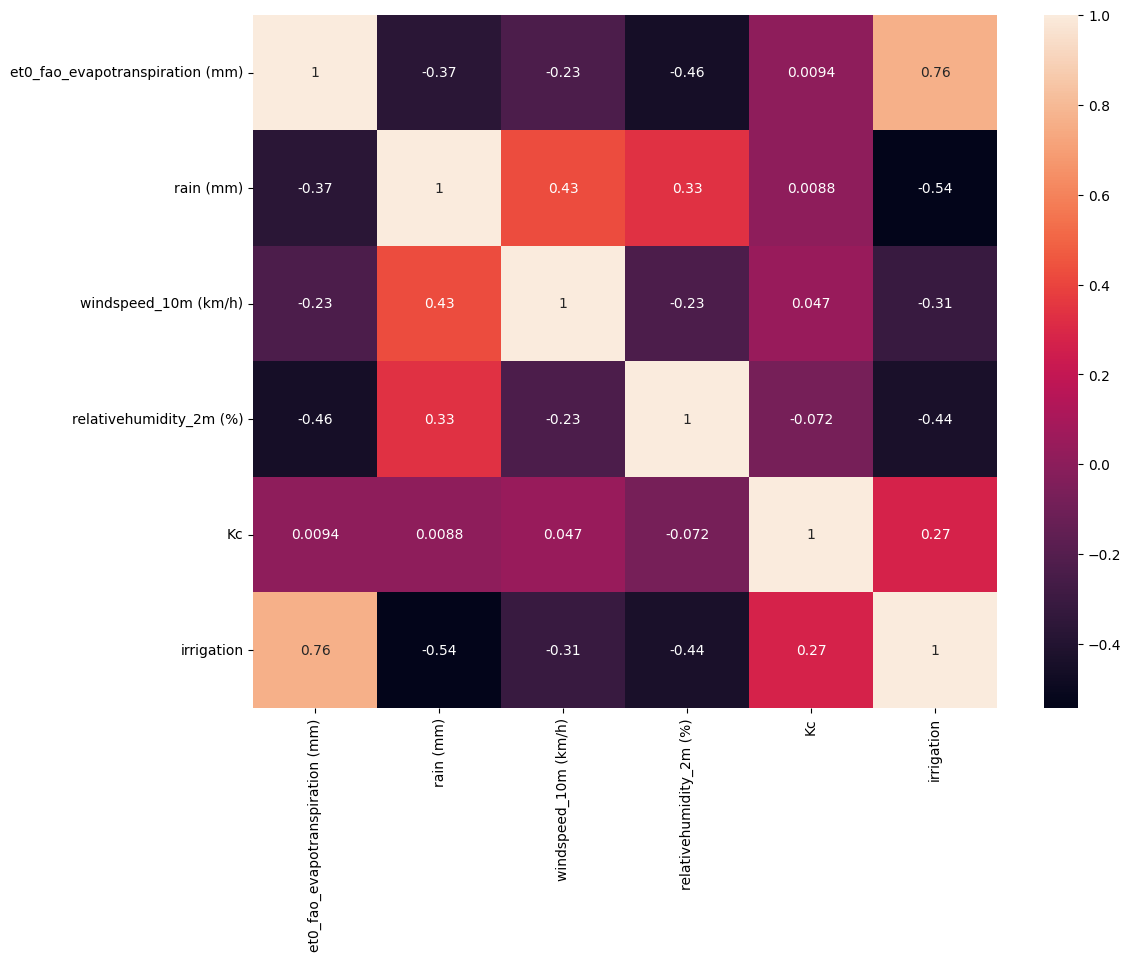

In [26]:
corrmatrix = irrigazione.corr()
#aumentare la dimensione della figura
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, annot=True)

Bilanciamento Dati

<AxesSubplot: xlabel='irrigation', ylabel='count'>

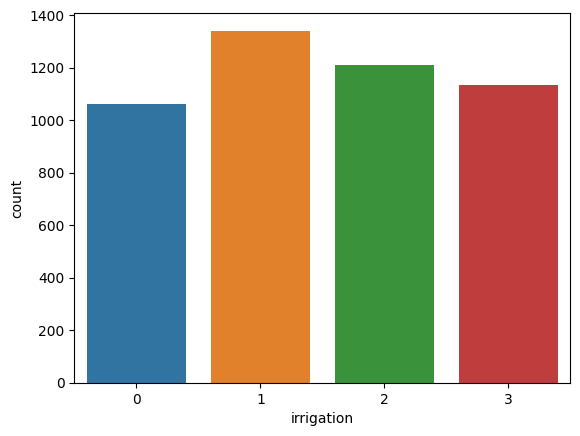

In [27]:
#La variabile categorica ha questi valori
sns.countplot(x='irrigation', data=irrigazione)

Tutto sommato il dataset è bilanciato 

Split Test and Train Data


In [28]:
irrigazione_X = irrigazione.drop('irrigation', axis=1)
irrigazione_y = irrigazione['irrigation']

In [29]:
#Applichiamo una normalizzazione ai dati
normalizer = StandardScaler()
transformer = normalizer.fit(irrigazione_X)
irrigazione_X_normalized = transformer.transform(irrigazione_X)
irr_X_train, irr_X_test, irr_y_train, irr_y_test = train_test_split(irrigazione_X_normalized, irrigazione_y, test_size=0.2)

In [30]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(irr_X_train, irr_y_train)
pred_clf = tree_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       222
           1       0.98      0.98      0.98       284
           2       0.97      0.96      0.96       246
           3       0.97      0.99      0.98       198

    accuracy                           0.98       950
   macro avg       0.98      0.98      0.98       950
weighted avg       0.98      0.98      0.98       950



In [31]:
#Numero di foglie dell'albero
print("Il numero di foglie generato dal classificatore è : " + str(tree_clf.get_n_leaves()))

Il numero di foglie generato dal classificatore è : 114


è inoltre interessante visualizzare graficamente l'albero

[Text(0.6074911347517731, 0.9615384615384616, 'rain (mm) <= -0.082\ngini = 0.748\nsamples = 3799\nvalue = [840, 1057, 965, 937]\nclass = Bassa'),
 Text(0.3280141843971631, 0.8846153846153846, 'et0_fao_evapotranspiration (mm) <= -0.488\ngini = 0.669\nsamples = 2923\nvalue = [12, 1019, 955, 937]\nclass = Bassa'),
 Text(0.14406028368794327, 0.8076923076923077, 'Kc <= 1.094\ngini = 0.218\nsamples = 882\nvalue = [12, 774, 96, 0]\nclass = Bassa'),
 Text(0.10017730496453901, 0.7307692307692307, 'et0_fao_evapotranspiration (mm) <= -0.635\ngini = 0.102\nsamples = 729\nvalue = [9, 690, 30, 0]\nclass = Bassa'),
 Text(0.06560283687943262, 0.6538461538461539, 'rain (mm) <= -0.147\ngini = 0.06\nsamples = 646\nvalue = [9, 626, 11, 0]\nclass = Bassa'),
 Text(0.03900709219858156, 0.5769230769230769, 'Kc <= 0.405\ngini = 0.035\nsamples = 622\nvalue = [0, 611, 11, 0]\nclass = Bassa'),
 Text(0.031914893617021274, 0.5, 'gini = 0.0\nsamples = 503\nvalue = [0, 503, 0, 0]\nclass = Bassa'),
 Text(0.04609929078

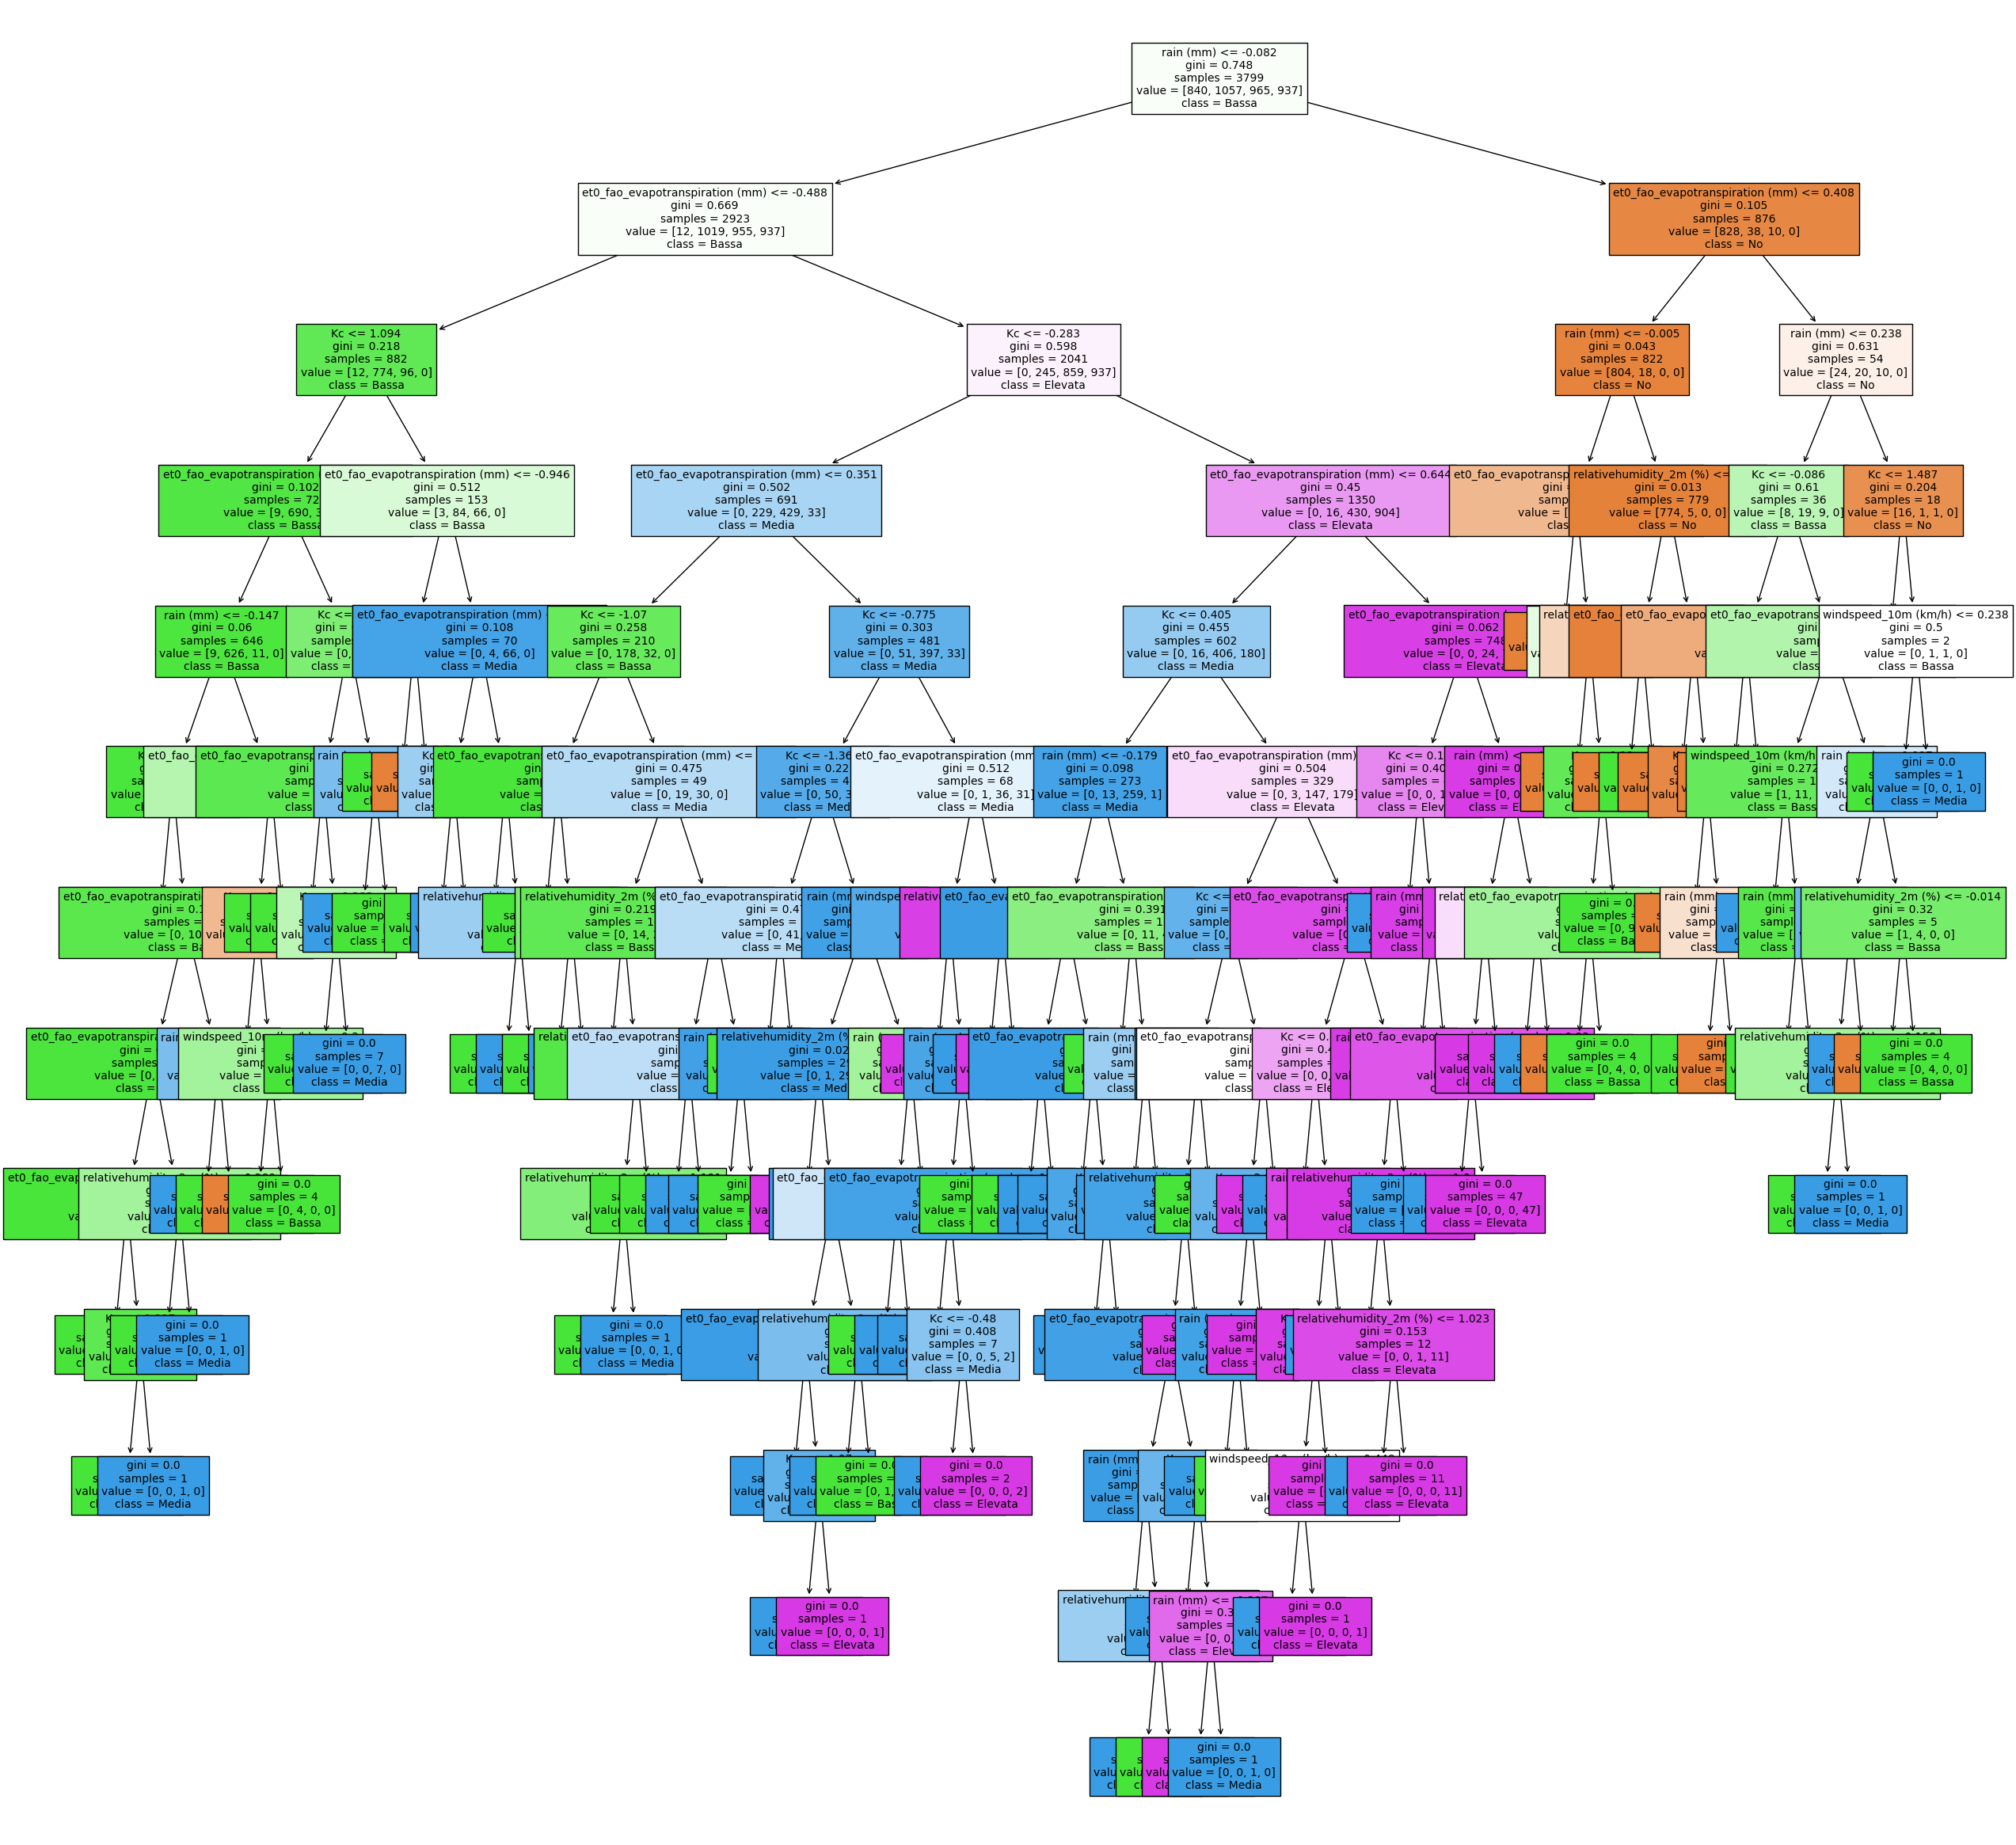

In [32]:
#plotta l'albero di decisione
plt.figure(figsize=(30,30))
tree.plot_tree(tree_clf, filled=True, fontsize=10, class_names=["No", "Bassa", "Media", "Elevata"], feature_names=irrigazione_X.columns)

In [33]:
bayes_clf = GaussianNB()
bayes_clf.fit(irr_X_train, irr_y_train)
pred_clf = bayes_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       222
           1       0.76      0.81      0.79       284
           2       0.73      0.65      0.69       246
           3       0.91      0.89      0.90       198

    accuracy                           0.83       950
   macro avg       0.83      0.83      0.83       950
weighted avg       0.82      0.83      0.82       950



In [34]:
forest_clf = RandomForestClassifier()
forest_clf.fit(irr_X_train, irr_y_train)
pred_clf = forest_clf.predict(irr_X_test)
print(classification_report(irr_y_test, pred_clf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       222
           1       0.95      0.98      0.97       284
           2       0.98      0.93      0.95       246
           3       0.97      0.99      0.98       198

    accuracy                           0.97       950
   macro avg       0.97      0.97      0.97       950
weighted avg       0.97      0.97      0.97       950

